# De novo design

### Developers: Mat Bieniek, Ben Cree, Rachael Pirie, Josh Horton

* Add R-groups in user-defined positions
* Output ADMET properties
* Perform constrained optimisation
* Score poses
* Send output to free energy calculations

Open source, customisable, fast/easy to use.

In [1]:
import copy
import glob
import prody
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
from rgroup import RMol, RList, build_molecules, fix_receptor, optimise_in_receptor, RGroups, sort_conformers, ic50

<frozen importlib._bootstrap>:228: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.


In [2]:
%cd /home/c0065492/rgroups/dat/jnk1/jnk1_dat

/home/c0065492/rgroups/dat/jnk1/jnk1_dat


In [3]:
prefix = 'lig_' #to extract experimental data from ligands.yml

In [4]:
!wget -nc https://files.rcsb.org/download/2GMX.pdb
pdb = '2GMX.pdb'

File ‘2GMX.pdb’ already there; not retrieving.



In [5]:
RMol.set_gnina(loc='/home/c0065492/software/gnina')

In [6]:
# load the complex with the ligand
sys = prody.parsePDB(pdb)
#sys = prody.parsePDB('jnk1/2gmx.pdb')

rec = sys.select('not (nucleic or hetatm) and not water')
#mol = sys.select('resname 19H and chain A')
mol = sys.select('resname 0X5')

prody.writePDB('rec.pdb', rec)
#prody.writePDB('lig.pdb', mol)

@> 5966 atoms and 1 coordinate set(s) were parsed in 0.06s.


'rec.pdb'

In [7]:
#!wget 'https://models.rcsb.org/v1/5nev/ligand?auth_seq_id=301&label_asym_id=E&encoding=sdf&filename=5nev_E_72L.sdf' -O lig.sdf
#!obabel jnk1/core.sdf -O jnk1/coreh.sdf -p 7
!obabel -isdf core.sdf -osdf -O coreh.sdf -p 7
# ^manually modify the files if need be
%pwd

1 molecule converted


'/home/c0065492/rgroups/dat/jnk1/jnk1_dat'

In [8]:
# load the ligand
# rdkit doesn't do a good job with protonation, 
#init_mol = Chem.MolFromPDBFile('lig.pdb', removeHs=False)
#init_mol = Chem.AddHs(init_mol, addCoords=True)

init_mol = Chem.SDMolSupplier('coreh.sdf', removeHs=False)[0]

# get the R group representation of the rdkit Mol
rinit_mol = RMol(init_mol)

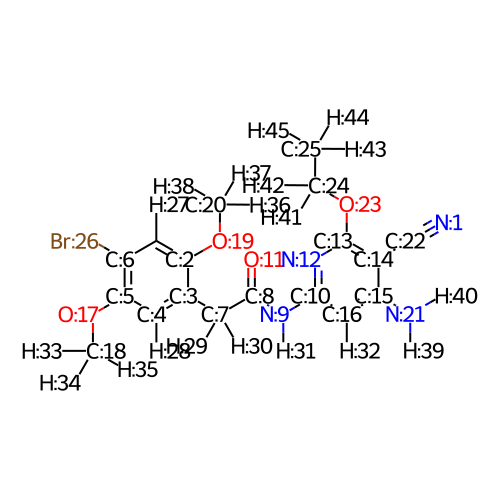

In [9]:
# select the atom to be replaced with the R group
rinit_mol.rep2D(idx=True, size=(500, 500))

In [10]:
glob.glob("*")

['test_best_conformers_18627.pdb',
 '2GMX.pdb',
 'rgroups_jnk1.ipynb',
 'test_best_conformers_18634.pdb',
 'optimised_coords_18634.pdb',
 'optimised_coords_18629.pdb',
 '17124',
 'scores_18637.dat',
 'ligands.yml',
 'convert.sh',
 'best_conformers_18634.pdb',
 'best_conformers_18636.pdb',
 'test_best_conformers_18629.pdb',
 'optimised_coords_17124.pdb',
 'db.json',
 'scores_18635.dat',
 '18628',
 'best_conformers_18629.sdf',
 'best_conformers_18625.pdb',
 'core.sdf',
 '2gmx.cif',
 'best_conformers_17124.sdf',
 'best_conformers_18635.pdb',
 'best_conformers_18635.sdf',
 'best_conformers_18634.sdf',
 'best_conformers_18628.pdb',
 'test_best_conformers_18628.pdb',
 'optimised_coords_18637.pdb',
 'best_conformers_18627.pdb',
 '18629',
 'coreh.sdf',
 'test_best_conformers_18637.pdb',
 'best_conformers_18637.pdb',
 'best_conformers_18627.sdf',
 'best_conformers_17124.pdb',
 '18635',
 '18634',
 'notebook_jnk1.db',
 'optimised_coords_18627.pdb',
 'out.png',
 'scores_18627.dat',
 'rec.pdb',
 'd

In [11]:
#remove 44 since all conformers clash with protein
ligand_ids = ['17124', '18625', '18626', '18627', '18628', '18629', '18634', '18635', '18636', '18637']

In [12]:
#ligand_ids = ['13c', '13d', '13h', '17c', '17h']
# read the rgroups 1 by 1 in a loop
#ligand_idss that there is only one -r.mol in each dir
rgroups = [Chem.MolFromMolFile(glob.glob(f'{ligand_id}/*.mol')[0], removeHs=False) for ligand_id in ligand_ids]
rgroups

In [13]:
ligand_ids[0] #to check what rgroup is failing optimisation or clash with protein

'17124'

In [14]:
# build a list of molecules
attachment_index = [45]
rmols = build_molecules(rinit_mol, attachment_index, rgroups)

Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7faa5ed31ca0> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7faa5ed31d00>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7faa5ed31d00> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7faa5ed31ca0>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7faa5ed31ca0> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7faa5ed31d00>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7faa5ed31d00> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7faa5ed31ca0>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7faa5ed31ca0> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7faa5ed31d00>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7faa5ed31d00> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7faa5ed31ca0>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7faa5ed31ca0> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7faa5ed31d00>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom o

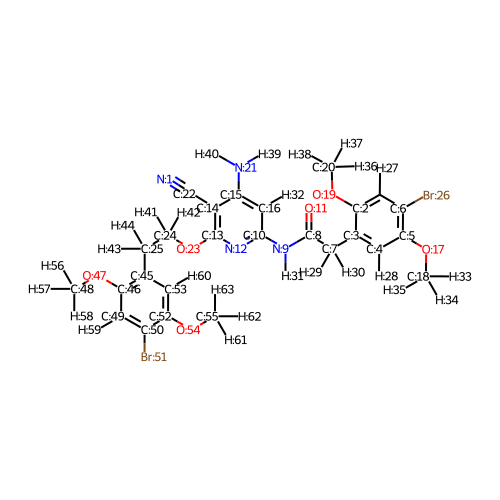

In [15]:
rmols[0].rep2D(idx=True, size=(500, 500))

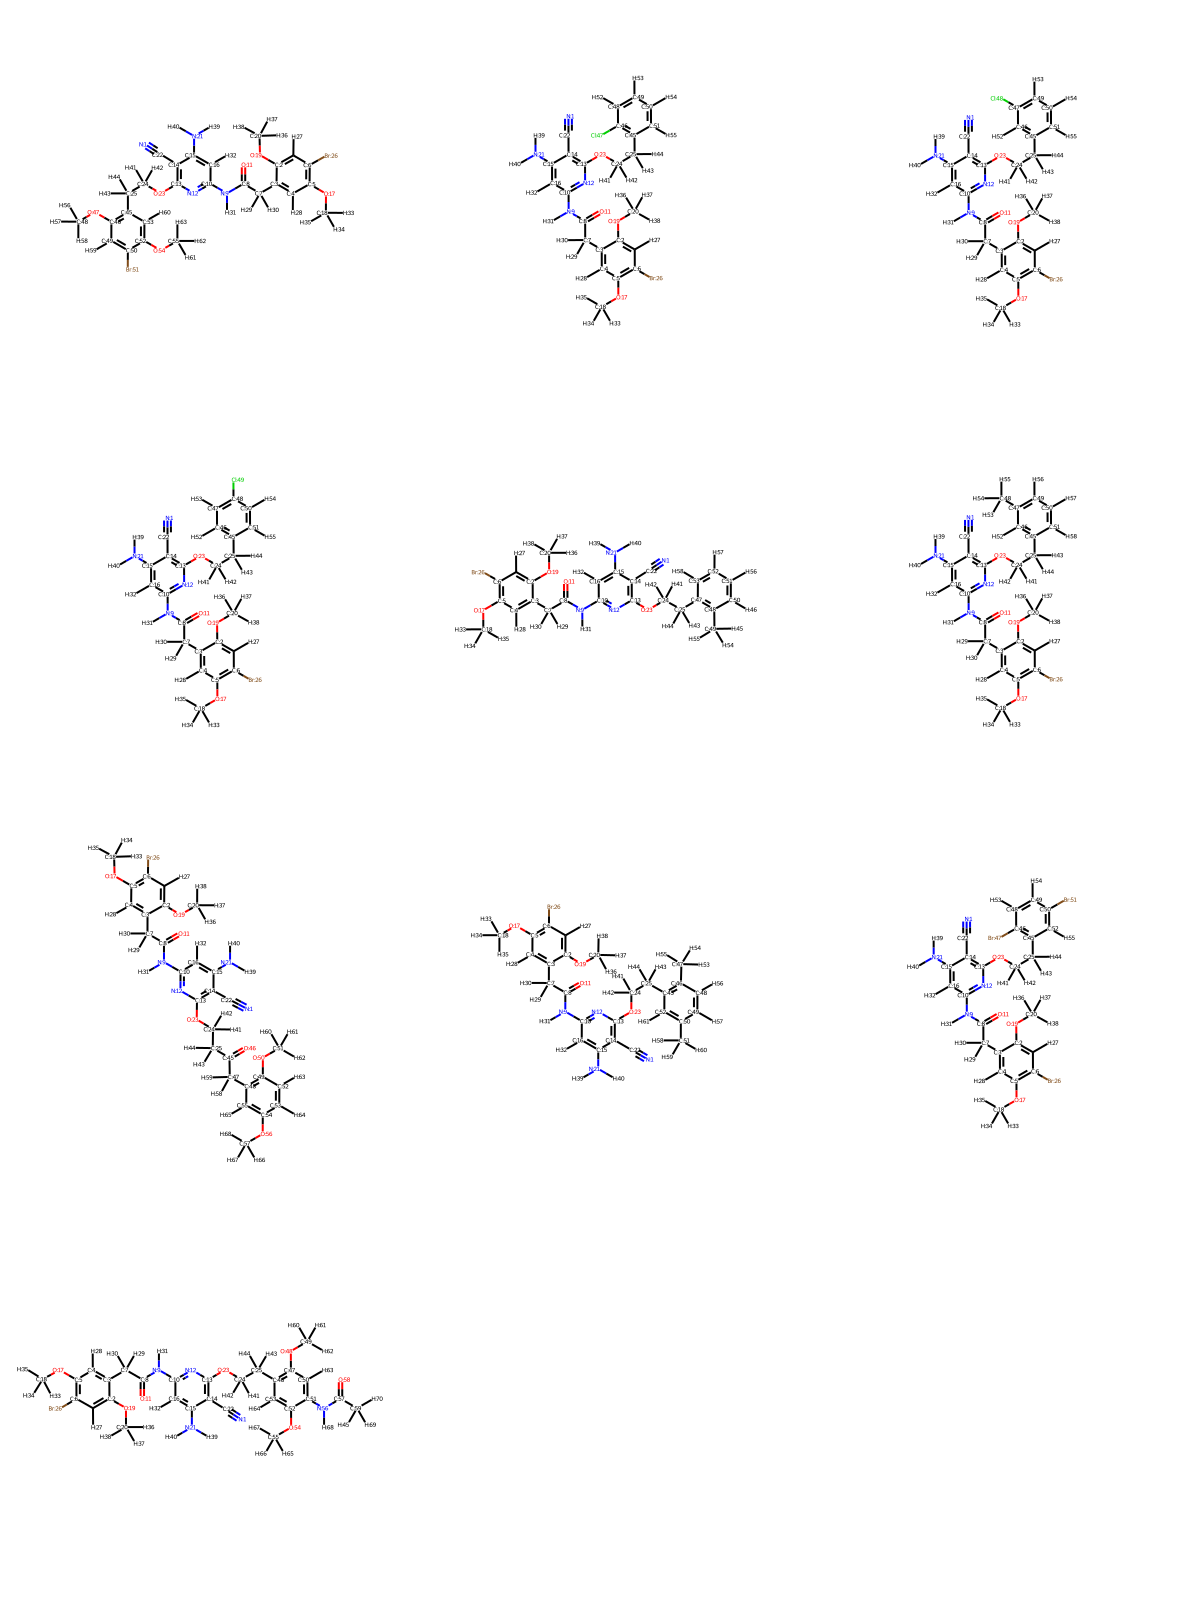

In [16]:
rmols.rep2D()

In [17]:
rmols[3].rep3D()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [18]:
rmols.toxicity()

MW  HBA  HBD     LogP  Pass_Ro5  has_pains  has_unwanted_subs  \
0  648.021909    9    2  4.89758      True      False              False   
0  544.051295    7    2  4.77128      True      False              False   
0  544.051295    7    2  4.77128      True      False              False   
0  544.051295    7    2  4.77128      True      False              False   
0  524.105917    7    2  4.42630      True      False              False   
0  524.105917    7    2  4.42630      True      False              False   
0  612.121961   10    2  4.09428      True      False              False   
0  538.121567    7    2  4.73472      True      False              False   
0  665.911291    7    2  5.64288     False      False              False   
0  627.132860   10    3  4.09348      True      False              False   

   has_prob_fgs  synthetic_accessibility  
0         False                 5.493862  
0         False                 7.850091  
0         False                 7.850091  
0         False                 7.850091  
0         False                 6.148138  
0         False                 6.148138  
0         False                 6.987719  
0         False                 6.807847  
0         False                 7.720078  
0         False                 7.190904

In [19]:
rmols.generate_conformers(num_conf=200,
                         minimum_conf_rms=0.5,
                         flexible = [43,44,25]
                         )

RMol index 0
removed 144 duplicated conformations
RMol index 1
removed 176 duplicated conformations
RMol index 2
removed 184 duplicated conformations
RMol index 3
removed 181 duplicated conformations
RMol index 4
removed 174 duplicated conformations
RMol index 5
removed 165 duplicated conformations
RMol index 6
removed 32 duplicated conformations
RMol index 7
removed 149 duplicated conformations
RMol index 8
removed 182 duplicated conformations
RMol index 9
removed 64 duplicated conformations


In [20]:
#rmol.rep3D(template=True)

In [21]:
rmols.GetNumConformers()

[57, 25, 17, 20, 27, 36, 169, 52, 19, 137]

### Optimise conformers in context of protein

In [22]:
# fix the receptor file 
fix_receptor("rec.pdb", "rec_h.pdb")
# load back into prody
rec_fix = prody.parsePDB("rec_h.pdb")

@> 11973 atoms and 1 coordinate set(s) were parsed in 0.07s.


In [23]:
# filter by the protein clashes
rmols[2].rep3D(prody=rec_fix)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [24]:
rmols.removeConfsClashingWithProdyProt(rec_fix)

RMol index 0
Clash with the protein. Removing conformer id: 55
Clash with the protein. Removing conformer id: 54
Clash with the protein. Removing conformer id: 52
Clash with the protein. Removing conformer id: 51
Clash with the protein. Removing conformer id: 50
Clash with the protein. Removing conformer id: 49
Clash with the protein. Removing conformer id: 48
Clash with the protein. Removing conformer id: 47
Clash with the protein. Removing conformer id: 46
Clash with the protein. Removing conformer id: 45
Clash with the protein. Removing conformer id: 44
Clash with the protein. Removing conformer id: 43
Clash with the protein. Removing conformer id: 42
Clash with the protein. Removing conformer id: 40
Clash with the protein. Removing conformer id: 39
Clash with the protein. Removing conformer id: 38
Clash with the protein. Removing conformer id: 37
Clash with the protein. Removing conformer id: 35
Clash with the protein. Removing conformer id: 34
Clash with the protein. Removing conf

In [25]:
rmols.GetNumConformers()

[8, 11, 5, 9, 7, 4, 11, 13, 4, 4]

In [26]:
rmols[2].rep3D(prody=rec_fix)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [27]:
# opt_mol, energies
energies = rmols.optimise_in_receptor(
    receptor_file="rec_h.pdb", 
    ligand_force_field="openff", 
    use_ani=True,
    sigma_scale_factor=0.8,
    relative_permittivity=4
)

RMol index 0


Optimising conformer: 100%|███████████████████████| 8/8 [02:37<00:00, 19.73s/it]


RMol index 1


Optimising conformer: 100%|█████████████████████| 11/11 [03:06<00:00, 16.97s/it]


RMol index 2


Optimising conformer: 100%|███████████████████████| 5/5 [01:49<00:00, 21.96s/it]


RMol index 3


Optimising conformer: 100%|███████████████████████| 9/9 [02:48<00:00, 18.75s/it]


RMol index 4


Optimising conformer: 100%|███████████████████████| 7/7 [01:54<00:00, 16.35s/it]


RMol index 5


Optimising conformer: 100%|███████████████████████| 4/4 [02:05<00:00, 31.33s/it]


RMol index 6


Optimising conformer: 100%|█████████████████████| 11/11 [03:16<00:00, 17.88s/it]


RMol index 7


Optimising conformer: 100%|█████████████████████| 13/13 [04:14<00:00, 19.59s/it]


RMol index 8


Optimising conformer: 100%|███████████████████████| 4/4 [01:13<00:00, 18.36s/it]


RMol index 9


Optimising conformer: 100%|███████████████████████| 4/4 [01:50<00:00, 27.66s/it]


In [28]:
rmols[0].rep3D()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [29]:
for i in range(len(ligand_ids)):
    rmols[i].to_file("optimised_coords_" + str(ligand_ids[i]) + ".pdb")

In [30]:
final_energies = rmols.sort_conformers(energy_range=5)

RMol index 0
RMol index 1
RMol index 2
RMol index 3
RMol index 4
RMol index 5
RMol index 6
RMol index 7
RMol index 8
RMol index 9


In [31]:
len(ligand_ids) == len(rmols) #check theyre equal or very bad and silent things happen

True

In [32]:
for i in range(len(ligand_ids)):
    rmols[i].to_file("test_best_conformers_" + str(ligand_ids[i]) + ".pdb")

In [33]:
#RMol.set_gnina(loc='gnina')

In [34]:
CNNscores = rmols.gnina(receptor_file="rec_h.pdb") 

RMol index 0
RMol index 1
RMol index 2
RMol index 3
RMol index 4
RMol index 5
RMol index 6
RMol index 7
RMol index 8
RMol index 9


In [35]:
%pwd

'/home/c0065492/rgroups/dat/jnk1/jnk1_dat'

In [36]:
ic50_scores = []
for i in range(len(CNNscores)):
    ic50_scores.append([ic50(x) for x in CNNscores[i]])

In [37]:
for i in range(len(ic50_scores)):
    with open('scores_' + str(ligand_ids[i]) + '.dat', 'w') as f:
        for x in range(len(ic50_scores[i])):
            f.write(str(ic50_scores[i][x])+'\n')

In [38]:
lowest = []
for i in range(len(ic50_scores)):
    lowest.append(ic50_scores[i][0])

In [39]:
import yaml
with open("ligands.yml", "r") as stream:
    try:
        data = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
suffix = '-1'
experimental = []
for i in range(len(ligand_ids)):
    if data[prefix + str(ligand_ids[i])+suffix]['measurement']['unit'] == 'nM':
        print('found nM')
        experimental.append(data[prefix+ str(ligand_ids[i])+suffix]['measurement']['value'])
    elif data[prefix + str(ligand_ids[i])]['measurement']['unit'] == 'um':
        experimental.append(1000*data[prefix+ str(ligand_ids[i])+suffix]['measurement']['value'])
    else:
        print('UNKNOWN UNIT - SKIPPING')
experimental 

found nM
found nM
found nM
found nM
found nM
found nM
found nM
found nM
found nM
found nM


[77, 1100, 300, 580, 400, 420, 45, 4400, 3000, 35]

In [40]:
import dill
%cd ~/rgroups/dat/jnk1/jnk1_dat
#dill.load_session('notebook_jnk1_jan11.db')

/home/c0065492/rgroups/dat/jnk1/jnk1_dat


In [41]:
import pandas as pd

name = [ligand_ids[i:i+1] for i in range(0, len(ligand_ids), 1)]
energies = [i[0] for i in final_energies]
cnn = [i[0] for i in CNNscores]
ic50 = [i[0] for i in ic50_scores]
expt = [i for i in experimental]
output = pd.DataFrame({'ID' : name, 'Final energies' : energies, 'Gnina score' : cnn, 'Gnina IC50 / nM' : ic50, 'Experimental IC50 / nM' : expt})
output

ID  Final energies  Gnina score  Gnina IC50 / nM  \
0  [17124]             0.0      7.39641        40.141168   
1  [18625]             0.0      7.32213        47.628840   
2  [18626]             0.0      7.37961        41.724390   
3  [18627]             0.0      7.35443        44.215038   
4  [18628]             0.0      7.31037        48.936173   
5  [18629]             0.0      7.37121        42.539267   
6  [18634]             0.0      7.73960        18.213776   
7  [18635]             0.0      7.43465        36.757841   
8  [18636]             0.0      7.52764        29.672900   
9  [18637]             0.0      7.88057        13.165277   

   Experimental IC50 / nM  
0                      77  
1                    1100  
2                     300  
3                     580  
4                     400  
5                     420  
6                      45  
7                    4400  
8                    3000  
9                      35

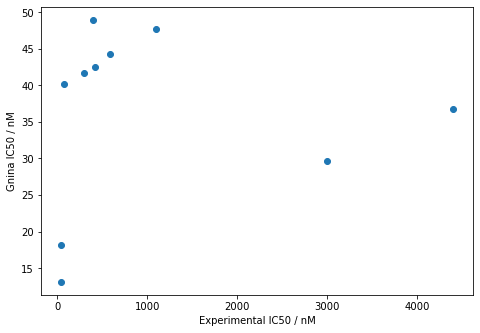

In [42]:
import matplotlib.pyplot as plt
import numpy as np
#ligands 27 & 28 have stereochem issues
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(experimental, lowest) #, color='black', marker='x')
ax.set_xlabel('Experimental IC50 / nM')
ax.set_ylabel('Gnina IC50 / nM')

x = np.linspace(0,25,25)
#ax.plot(x, x, color='black', linestyle='--')

plt.savefig('out.png', bbox_inches='tight')
plt.show()

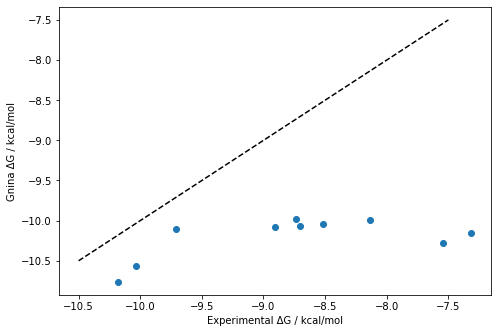

In [43]:
# convert nM to M
lowestinM = [ i * 1e-9 for i in lowest]
exptinM = [ i * 1e-9 for i in expt]

RT = 0.593 # kcal/mol

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])

# DG = RTln(K)
ax.scatter(RT*np.log(exptinM), RT*np.log(lowestinM)) #, color='black', marker='x')
ax.set_xlabel('Experimental \u0394G / kcal/mol')
ax.set_ylabel('Gnina \u0394G / kcal/mol')

x = np.linspace(-10.5,-7.5,10)
ax.plot(x, x, color='black', linestyle='--')
A = np.vstack([experimental, np.ones(len(experimental))]).T
m, c = np.linalg.lstsq(A, lowest, rcond=None)[0]

m = "{:.2f}".format(m)
r = "r^2 =" + str(m)
plt.annotate(r, (-10,-6))
plt.savefig('deltaG2.png', bbox_inches='tight')
plt.show()

In [44]:
import dill
dill.dump_session('notebook_jnk1_jan16.db')

In [45]:
ligand_id_idx = []

In [46]:
for counter, l in enumerate(CNNscores, 1):
    if len(l) == 2:
        ligand_id_idx.append(counter-1)

In [47]:
CNNscores

[[7.39641, 7.39687, 7.66814, 7.56125, 7.5558, 7.55393, 7.54802],
 [7.32213, 7.61703, 7.39773, 7.39033, 7.35445, 7.50003, 7.82226],
 [7.37961, 7.36727],
 [7.35443, 7.35039, 7.37645],
 [7.31037, 7.30898, 7.37909, 7.44764, 7.4307],
 [7.37121, 7.33894],
 [7.7396, 7.73497, 7.71962],
 [7.43465,
  7.39886,
  7.39885,
  7.47589,
  7.29893,
  7.43121,
  7.68998,
  7.31021,
  7.31,
  7.30995,
  7.468],
 [7.52764],
 [7.88057, 7.69679]]

In [48]:
import yaml
with open("ligands.yml", "r") as stream:
    try:
        data = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
suffix = ''
experimental_filtered = []
for i in range(len(filtered_ids)):
    if data[prefix + str(filtered_ids[i])+suffix]['measurement']['unit'] == 'nM':
        print('found nM')
        experimental_filtered.append(data[prefix+ str(lfiltered_ids[i])+suffix]['measurement']['value'])
    elif data[prefix + str(filtered_ids[i])+suffix]['measurement']['unit'] == 'uM':
        print('found uM')
        experimental_filtered.append(1000*data[prefix+ str(filtered_ids[i])+suffix]['measurement']['value'])
    else:
        print('UNKNOWN UNIT - SKIPPING')
experimental_filtered

NameError: name 'filtered_ids' is not defined

In [59]:
import re
smina_affinities = []
with open('smina_scores.dat', 'r') as f:
    for line in f:
        affinity = re.findall(r'Affinity: (-?\d+.\d+)', str(line))
        try:
            smina_affinities.append(float(affinity[0]))
        except:
            pass

In [60]:
smina_affinities

[-4.54052,
 -5.10965,
 -5.33785,
 -5.92778,
 -4.86437,
 -5.8772,
 -3.89895,
 -5.5013,
 -5.11311,
 -6.68608]

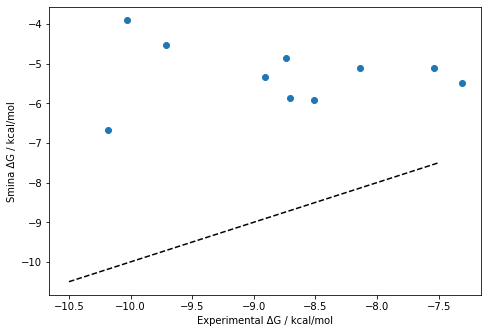

In [63]:
# convert nM to M
exptinM = [ i * 1e-9 for i in experimental]

RT = 0.593 # kcal/mol

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])

# DG = RTln(K)
ax.scatter(RT*np.log(exptinM), smina_affinities) #, color='black', marker='x')
ax.set_xlabel('Experimental \u0394G / kcal/mol')
ax.set_ylabel('Smina \u0394G / kcal/mol')

x = np.linspace(-10.5,-7.5,10)
ax.plot(x, x, color='black', linestyle='--')
A = np.vstack([experimental, np.ones(len(experimental))]).T
#m, c = np.linalg.lstsq(A, lowest, rcond=None)[0]

#m = "{:.2f}".format(m)
#r = "r^2 =" + str(m)
#plt.annotate(r, (-10,-6))
plt.savefig('deltaG2_smina.png', bbox_inches='tight')
plt.show()

In [54]:
len(experimental)

10

In [61]:
len(smina_affinities)

10